<a href="https://colab.research.google.com/github/AtlastDeepLearning/Intestinal-Parasite-Classification-LW-CNN/blob/main/Intestinal_Parasite_LW_CNN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install required packages
!pip install tensorflow
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite-runtime
!pip install efficientnet
!pip install imgaug albumentations

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 12.7 MB/s eta 0:00:00


In [15]:
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0
import logging
import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import logging
import datetime

In [16]:
import subprocess
import sys

def check_cuda():
    print("Python version:", sys.version)
    print("\nCUDA version:")
    try:
        nvcc_output = subprocess.check_output("nvcc --version", shell=True)
        print(nvcc_output.decode())
    except:
        print("CUDA not found or nvcc not in PATH")

    print("\nNVIDIA-SMI:")
    try:
        nvidia_smi_output = subprocess.check_output("nvidia-smi", shell=True)
        print(nvidia_smi_output.decode())
    except:
        print("nvidia-smi not found")

check_cuda()

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]

CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


NVIDIA-SMI:
Tue Jun 17 20:27:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-S

In [7]:
# Install the latest compatible cuDNN version
!pip install nvidia-cudnn-cu12==9.10.2.21

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 whi

In [17]:
import tensorflow as tf
import os

# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Print TensorFlow information
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("GPU Device Name: ", tf.test.gpu_device_name())

# Configure GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name:  /device:GPU:0
GPU memory growth enabled


In [18]:
class_names = [
    'ascaris_lumbricoides',
    'trichuris_trichiura',
    'hookworms',
    'enterobius_vermicularis',
]

In [19]:
def setup_logging():
    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    log_file = f'{log_dir}/training_{timestamp}.log'

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return log_file

def preprocess_image(img):
    try:
        img = img.astype(np.float32) / 255.0
        img = tf.image.per_image_standardization(img)
        return img
    except Exception as e:
        logging.error(f"Error in preprocessing: {str(e)}")
        return None

def save_model_version(model, version_info):
    version_dir = 'model_versions'
    if not os.path.exists(version_dir):
        os.makedirs(version_dir)

    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    version_path = f'{version_dir}/model_v{timestamp}'
    os.makedirs(version_path)

    model.save(f'{version_path}/model.h5')
    with open(f'{version_path}/version_info.json', 'w') as f:
        json.dump(version_info, f)

    logging.info(f"Model saved to {version_path}")
    return version_path

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
class LoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logging.info(f"Epoch {epoch+1} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [22]:
def validate_data_directories():
    train_dir = '/content/drive/MyDrive/MAPUA/dataset/train'
    val_dir = '/content/drive/MyDrive/MAPUA/dataset/validate'

    if not os.path.exists(train_dir) or not os.path.exists(val_dir):
        raise ValueError("Training or validation directory not found")

    for class_name in class_names:
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)

        train_count = len(os.listdir(train_class_dir))
        val_count = len(os.listdir(val_class_dir))

        logging.info(f"{class_name}: {train_count} training images, {val_count} validation images")

        if train_count < 10:
            logging.warning(f"Low number of training images for {class_name}: {train_count}")
        if val_count < 5:
            logging.warning(f"Low number of validation images for {class_name}: {val_count}")

# Run validation
try:
    validate_data_directories()
    logging.info("Data validation completed successfully")
except Exception as e:
    logging.error(f"Data validation failed: {str(e)}")
    raise

In [29]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/MAPUA/dataset/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/MAPUA/dataset/validate',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 4000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [31]:
def evaluate_model(model, validation_generator, class_names):
    try:
        y_pred = []
        y_true = []

        for i in range(len(validation_generator)):
            x, y = validation_generator[i]
            preds = model.predict(x)
            y_pred.extend(np.argmax(preds, axis=1))
            y_true.extend(np.argmax(y, axis=1))

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()

        report = classification_report(y_true, y_pred,
                                    target_names=class_names,
                                    output_dict=True)
        logging.info("Classification Report:")
        logging.info(json.dumps(report, indent=4))

        system_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        logging.info(f"System Accuracy: {system_accuracy:.4f}")

        return report, system_accuracy

    except Exception as e:
        logging.error(f"Error in evaluation: {str(e)}")
        return None, None

In [32]:
# Initialize logging
log_file = setup_logging()
logging.info("Starting training process")

# Define number of classes
num_classes = 4  # Your actual number of classes

# Create model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Changed from 5 to num_classes
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        ),
        LoggingCallback(),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ],
    verbose=1
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5950 - loss: 1.0169 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1111s 17s/step - accuracy: 0.5976 - loss: 1.0118 - val_accuracy: 0.6393 - val_loss: 0.8801 - learning_rate: 1.0000e-04
Epoch 2/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9219 - loss: 0.2759

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 761ms/step - accuracy: 0.9219 - loss: 0.2759 - val_accuracy: 0.6354 - val_loss: 0.8825 - learning_rate: 1.0000e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9440 - loss: 0.1874

62/62 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.9442 - loss: 0.1867 - val_accuracy: 0.7526 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 4/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 1.0000 - loss: 0.0360

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 0.7539 - val_loss: 0.7429 - learning_rate: 1.0000e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9776 - loss: 0.0899

62/62 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.9776 - loss: 0.0899 - val_accuracy: 0.8008 - val_loss: 0.6184 - learning_rate: 1.0000e-04
Epoch 6/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9688 - loss: 0.0459

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 591ms/step - accuracy: 0.9688 - loss: 0.0459 - val_accuracy: 0.7982 - val_loss: 0.6058 - learning_rate: 1.0000e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9839 - loss: 0.0545

62/62 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.9839 - loss: 0.0545 - val_accuracy: 0.8229 - val_loss: 0.5725 - learning_rate: 1.0000e-04
Epoch 8/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9844 - loss: 0.0539

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 593ms/step - accuracy: 0.9844 - loss: 0.0539 - val_accuracy: 0.8294 - val_loss: 0.5346 - learning_rate: 1.0000e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9912 - loss: 0.0305

62/62 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9912 - loss: 0.0306 - val_accuracy: 0.8581 - val_loss: 0.4366 - learning_rate: 1.0000e-04
Epoch 10/10
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9844 - loss: 0.0372

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 604ms/step - accuracy: 0.9844 - loss: 0.0372 - val_accuracy: 0.8542 - val_loss: 0.4337 - learning_rate: 1.0000e-04


In [35]:
# Save model version
version_info = {
    'model_type': 'EfficientNetB0',
    'input_shape': (224, 224, 3),
    'num_classes': 4,
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'final_accuracy': history.history['accuracy'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1]
}
model_version_path = save_model_version(model, version_info)

# Run evaluation
report, system_accuracy = evaluate_model(model, validation_generator, class_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [37]:
# Define representative dataset generator
def representative_dataset_gen():
    num_calibration_samples = 100
    for i in range(min(num_calibration_samples, len(validation_generator))):
        image_batch, _ = validation_generator[i]
        yield [image_batch]

# Convert to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.target_spec.supported_types = [tf.int8]
converter.full_integer_quantization = True

# Convert the model
tflite_model = converter.convert()

# Save TFLite model
with open('parasite_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

Saved artifact at '/tmp/tmpmagg87bd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_932')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136695458951440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458944720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458954320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458946256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458947408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458946064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458953168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458945488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458953360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136695458955088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366954589

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite model saved successfully!


In [38]:
# Test model with a single image
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def test_single_image(image_path):
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Resize to match model's input size
        img_array = np.array(img)
        img_array = img_array.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class_idx = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class_idx] * 100

        # Get class name
        predicted_class = class_names[predicted_class_idx]

        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
        plt.show()

        # Print detailed results
        print("\nDetailed Results:")
        print("-" * 30)
        for idx, (class_name, prob) in enumerate(zip(class_names, prediction[0])):
            print(f"{class_name}: {prob*100:.2f}%")

    except Exception as e:
        print(f"Error processing image: {str(e)}")

# Example usage:
# test_single_image('path/to/your/image.jpg')

In [42]:
# A simpler approach to test the model with an image
def test_model_with_image(image_path):
    """
    Test the model with a single image file
    Args:
        image_path: Path to the image file to test
    """
    try:
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(
            image_path,
            target_size=(224, 224)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class_idx = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class_idx] * 100

        # Get class name
        predicted_class = class_names[predicted_class_idx]

        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
        plt.show()

        # Print detailed results
        print("\nDetailed Results:")
        print("-" * 30)
        for idx, (class_name, prob) in enumerate(zip(class_names, prediction[0])):
            print(f"{class_name}: {prob*100:.2f}%")

    except Exception as e:
        print(f"Error processing image: {str(e)}")

# Example usage:
print("To test an image, use:")
print("test_model_with_image('path/to/your/image.jpg')")
print("\nFor example, you can test with one of your validation images:")
print("test_model_with_image('validate/ascaris_lumbricoides/Ascaris lumbricoides_0033.jpg')")


To test an image, use:
test_model_with_image('path/to/your/image.jpg')

For example, you can test with one of your validation images:
test_model_with_image('validate/ascaris_lumbricoides/Ascaris lumbricoides_0033.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


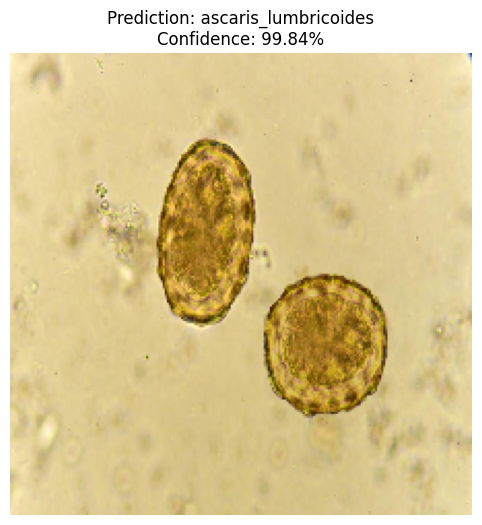


Detailed Results:
------------------------------
ascaris_lumbricoides: 99.84%
trichuris_trichiura: 0.10%
hookworms: 0.05%
enterobius_vermicularis: 0.02%


In [43]:
test_model_with_image('/content/drive/MyDrive/MAPUA/testimage.jpg')